# Source:
SEIR Algorithm to model evolution of Coronavirus based on: 
<br> <br>
K. Prem et al., "The effect of control strategies to reduce social mixing on outcomes of the COVID-19 epidemic in Wuhan, China: a modelling study," The Lancet Public Health, 2020, doi: 10.1016/s2468-2667(20)30073-6.
<br> 
# Model:
SEIR Stands for: <br>
S - Susceptible <br>
E - Exposed <br>
I - Infected <br>
R - Removed <br>
<br>
Population has been devided into age groups spanning five years, with the last group collecting all 75+ year olds. Each age group $$i$$ can be modelled separatelly.

The model is driven with the following equations: <br>
$$ N(t) = S(t) + E(t) + I(t) + R(t) $$ 
$$ S_{i,t+1} = S_{i,t} -\beta S_{i,t} \sum_{j = 1}^{n} C_{i,j}I_{j,t}^{c}/Pop_{j} - \alpha\beta \sum_{j = 1}^{n} C_{i,j}I_{j,t}/Pop_{j}^{sc} $$
$$ E_{i,t+1} = \beta S_{i,t} \sum_{j = 1}^{n} C_{i,j}I_{j,t}^{c}/Pop_{j} + \alpha\beta S_{i,t} \sum_{j = 1}^{n} C_{i,j}I_{j,t}^{sc}/Pop_{j} + (1-\kappa)E_{i,t}  $$
$$ I_{j,t+1}^{c} = \rho_{i} \kappa E_{i,t} + (1+\gamma)I_{j,t}^{c}$$
$$ I_{j,t+1}^{sc} = (1-\rho_{i}) \kappa E_{i,t} + (1+\gamma)I_{j,t}^{sc}$$
$$ R_{i,t+1} = R_{i,t} + \gamma I_{j,t}^{c} + \gamma I_{j,t}^{sc} $$ 
<br> 

## Parameters:
$ \beta $ Scaled to the value of $R_{0}$ ($\beta = R_{0}*\gamma*max(eig(C))$ <br>
$ C_{i,j} $ Contact parameter between different age groups <br>
$ \kappa = 1-\exp(\frac{-1}{d_{L}}) $  is the daily probability of an exposed individual becoming infectious (with $d_{L}$ being
the average incubation period) <br>
$ \gamma = 1-\exp(\frac{-1}{d_{I}}) $ is the daily probability that an infected individual recovers when the average duration of infection is $d_{I}$ <br> 
$\rho$ is probability of the infected to have symptoms, while $(1-\rho)$ is the probability to be asymptomatic<br>
$ \alpha $ - probability of getting infected from subclinical<br> 

## Numerical values implemented in the paper
$$ R_{0} = 2.2 $$
$$ d_{L} = 6.4 $$
$$ d_{I} = \{ 3, 7 \} $$
$$ I_{0} = \{ 200, 2000 \} $$
$$ \rho_{i} = \{ 0, 0.4 \} \textrm{for} i \le 4 $$ 
$$ \rho_{i} = \{ 0, 0.8 \} \textrm{for} i > 4 $$ 
$$ \alpha = 0.25 $$

In [1]:
import numpy as np
import pandas as pd
import pyreadr
import matplotlib.pyplot as plt

In [148]:
## Import population data
age_data_url =  'https://raw.githubusercontent.com/kieshaprem/covid19-agestructureSEIR-wuhan-social-distancing/master/data/wuhanpop.csv';
age_strc = pd.read_csv(age_data_url)

interaction_file = 'C://Users//Aleksander//PycharmProjects//coronus-ml2//notebooks//marian//data//contacts_all.csv';
Cmat = pd.read_csv(interaction_file); # also works for Rds
Cmat = Cmat.iloc[:,1:].to_numpy();
# Create M matrix (C scaled by age)
M = Cmat;
for ii in range(0,Cmat.shape[0]):
    for jj in range(0, Cmat.shape[1]):
        M[ii][jj] = Cmat[ii][jj]*age_strc.propage[ii]/age_strc.propage[jj]; 
M_eig = np.linalg.eig(M)
max_eig = np.max(np.real(M_eig[0]));

    agegroup   popage   propage
0          1   407903  0.037887
1          2   282264  0.026218
2          3   817453  0.075928
3          4  1430272  0.132848
4          5   896025  0.083226
5          6   842295  0.078235
6          7   701197  0.065129
7          8   864953  0.080340
8          9  1049332  0.097465
9         10   431113  0.040043
10        11   691750  0.064252
11        12   726228  0.067454
12        13   568724  0.052825
13        14   352535  0.032745
14        15   273800  0.025431
15        16   430356  0.039973


In [174]:
## Initialise parameters
# Model parameters
R0 = 2.2;
dL = 6.4;
kappa = 1-np.exp(-1/dL);
dI = 7;
gamma = 1-np.exp(-1/dI);
I0 = 2000;
rho = np.zeros([16,1]);
rho[0:3] = 0.4;
rho[3:-1] = 0.8;
alpha = 0.25;
beta = R0*gamma/max_eig;
# Assume outbreak started on 10th of January
n_days = 440;


# Population
N = 11e6;
S = np.zeros([16,n_days]);
E = np.zeros([16,n_days]);
Ic = np.zeros([16,n_days]);
Isc = np.zeros([16,n_days]);
R = np.zeros([16,n_days]);

Isc[:,0] = np.round(I0*age_strc.propage.to_numpy());
S[:,0] =  np.round(N*age_strc.propage.to_numpy())-Isc[:,0];


In [175]:
# Explore the outbreak
for day in range(1,n_days):
    for grp in range(0, 16):
        S[grp, day] = S[grp, day-1]-beta*S[grp, day-1]*np.dot(Cmat[grp,:], Ic[:, day-1]/age_strc.popage[grp])-alpha*beta*S[grp, day-1]*np.dot(Cmat[grp,:], Isc[:, day-1]/age_strc.popage[grp])
        E[grp, day] = beta*S[grp, day-1]*np.dot(Cmat[grp,:], Ic[:, day-1]/age_strc.popage[grp])+alpha*beta*S[grp, day-1]*np.dot(Cmat[grp,:], Isc[:, day-1]/age_strc.popage[grp])+(1-kappa)*E[grp, day-1];
        Ic[grp, day] = rho[grp]*kappa*E[grp, day-1]+(1-gamma)*Ic[grp, day-1];
        Isc[grp, day] = (1-rho[grp])*kappa*E[grp, day-1]+(1-gamma)*Isc[grp, day-1];
        R[grp, day] = R[grp, day-1] + gamma*Ic[grp, day-1] + gamma*Isc[grp, day-1];

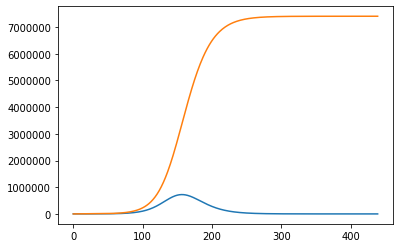

In [176]:
# Save data to pandas frame
epi_data = {'Susceptible': np.sum(S,axis = 0),
           'Exposed': np.sum(E,axis = 0),
           'Infected': np.sum(Ic, axis = 0)+np.sum(Isc,axis = 0),
           'Removed': np.sum(R,axis = 0)}

epidemy = pd.DataFrame(epi_data, columns = ['Susceptible', 'Exposed', 'Infected', 'Removed'])

epidemy.Infected.plot()
epidemy.Removed.plot()


In [172]:
print(beta)
print(gamma)
print(kappa)

0.09904354749621032
0.28346868942621073
0.14465467269257748


In [134]:
grp = 4
day = 1
S[grp, day] = S[grp, day-1]-beta*np.dot(Cmat[grp,:], Ic[:, day-1])-alpha*beta*np.dot(Cmat[grp,:], Isc[:, day-1])
print(beta)
print(np.dot(Cmat[grp,:], Isc[:, day-1]))
print(alpha*beta*np.dot(Cmat[grp,:], Isc[:, day-1]))
print(S[grp,day-1])




0.08715832179666509
183.93047661628012
4.007767917283932
915466.0
